10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


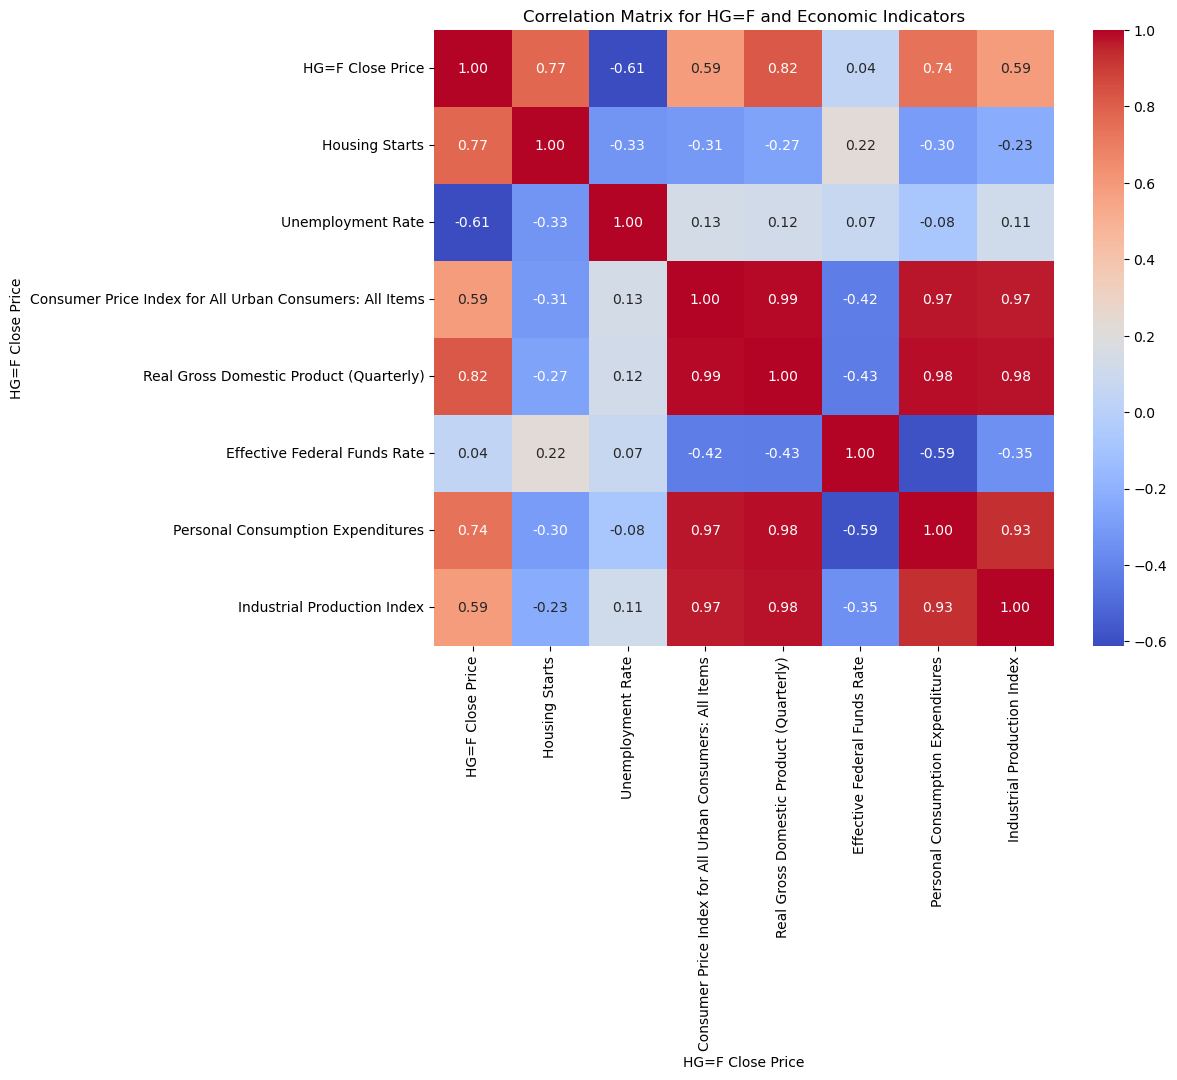

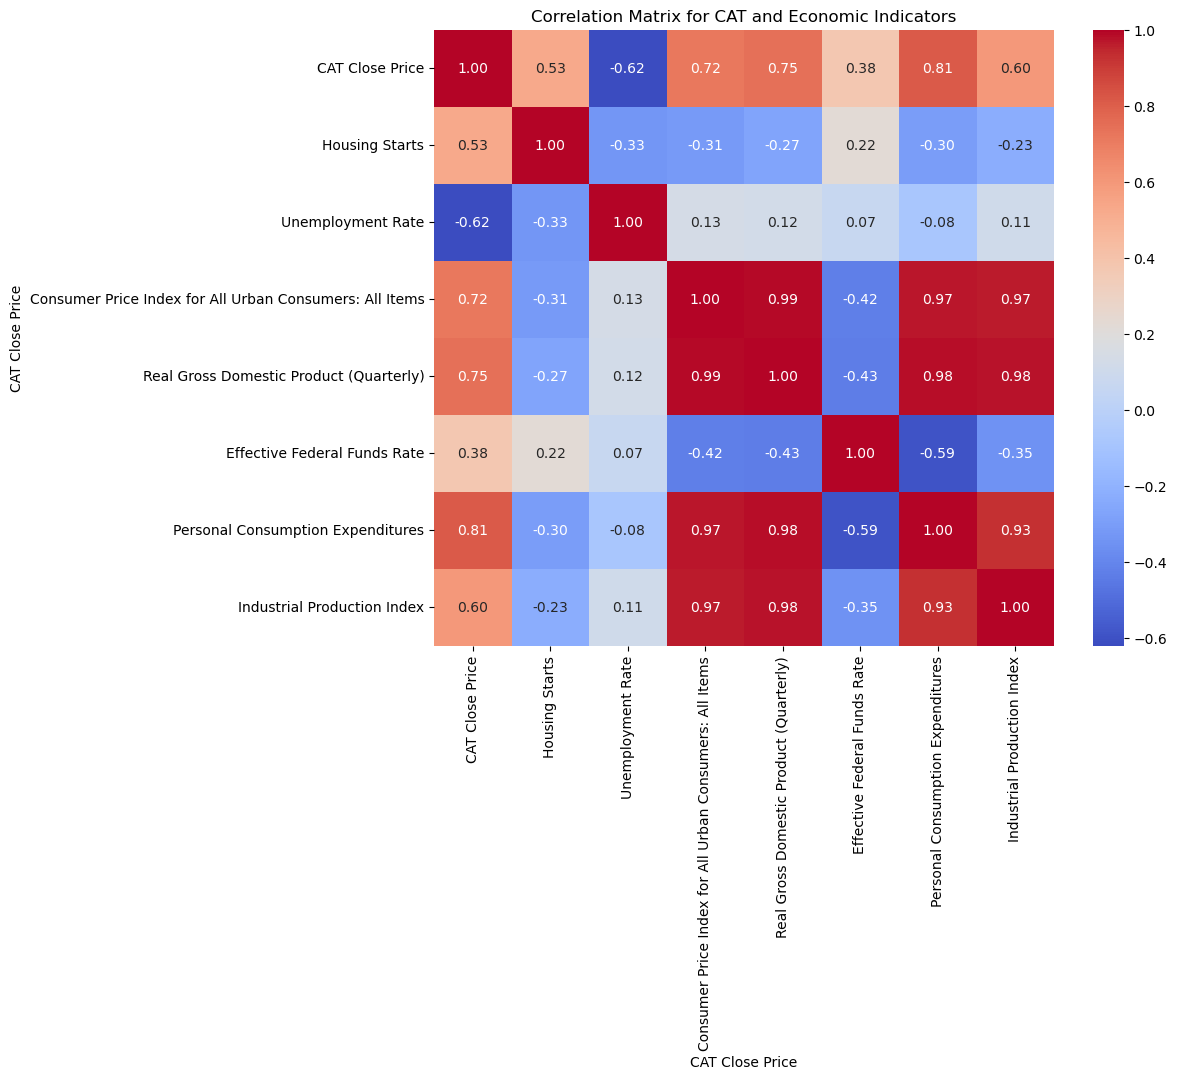

In [19]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from fredapi import Fred
import plotly.graph_objects as go
import plotly.io as pio

class StockAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the StockAnalysis object.

        Parameters:
            tickers (list): List of tickers for which to perform the analysis.
            start_date (str): Start date for historical data (YYYY-MM-DD).
            end_date (str): End date for historical data (YYYY-MM-DD).
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.all_traces = []
        self.closing_prices_df = pd.DataFrame()

    def fetch_stock_data(self, ticker):
        """
        Fetch historical stock data for the given ticker from Yahoo Finance.

        Parameters:
            ticker (str): Stock ticker symbol.

        Returns:
            pandas.DataFrame: DataFrame containing the historical stock data.
        """
        return yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)

    def prepare_prophet_data(self, stock_data):
        prophet_data = stock_data.reset_index()[["Date", "Close"]]
        prophet_data.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
        return prophet_data

    def calculate_bollinger_bands(self, stock_data):
        window = 20
        std_dev = 2
        stock_data["MA"] = stock_data["Close"].rolling(window=window).mean()
        stock_data["Upper"] = stock_data["MA"] + std_dev * stock_data["Close"].rolling(window=window).std()
        stock_data["Lower"] = stock_data["MA"] - std_dev * stock_data["Close"].rolling(window=window).std()
        return stock_data

    def identify_bullish_bearish_signals(self, stock_data):
        bullish_signals = stock_data[stock_data["Close"] > stock_data["Upper"]]["Close"]
        bearish_signals = stock_data[stock_data["Close"] < stock_data["Lower"]]["Close"]
        return bullish_signals, bearish_signals

    def create_traces_for_ticker(self, ticker, stock_data, forecast, bullish_signals, bearish_signals):
        traces = [
            go.Scatter(x=stock_data.index, y=stock_data["Upper"], mode="lines", name=f"{ticker} Upper Bollinger Band", line=dict(color="blue")),
            go.Scatter(x=stock_data.index, y=stock_data["Lower"], mode="lines", name=f"{ticker} Lower Bollinger Band", line=dict(color="blue")),
            go.Scatter(x=stock_data.index, y=stock_data["Close"], mode="lines", name=f"{ticker} Closing Price", line=dict(color="black")),
            go.Scatter(x=forecast["ds"], y=forecast["yhat"], mode="lines", name=f"{ticker} Prophet Forecast", line=dict(color="purple")),
            go.Scatter(x=bullish_signals.index, y=bullish_signals, mode="markers", name=f"{ticker} Bullish Signal", marker=dict(symbol="triangle-up", size=10, color="green")),
            go.Scatter(x=bearish_signals.index, y=bearish_signals, mode="markers", name=f"{ticker} Bearish Signal", marker=dict(symbol="triangle-down", size=10, color="red")),
            go.Scatter(x=forecast["ds"], y=forecast["trend"], mode="lines", name=f"{ticker} Trend Line", line=dict(color="orange", dash="dash"))
        ]
        return traces

    def visualize_all_ticker_data(self):
        for ticker in self.tickers:
            stock_data = self.fetch_stock_data(ticker)
            self.closing_prices_df[ticker] = stock_data["Close"]
            prophet_data = self.prepare_prophet_data(stock_data)
            model = Prophet(daily_seasonality=True)
            model.fit(prophet_data)
            future = model.make_future_dataframe(periods=365)  # 30 days forecast
            forecast = model.predict(future)
            stock_data = self.calculate_bollinger_bands(stock_data)
            bullish_signals, bearish_signals = self.identify_bullish_bearish_signals(stock_data)
            traces = self.create_traces_for_ticker(ticker, stock_data, forecast, bullish_signals, bearish_signals)
            self.all_traces.extend(traces)

        fig = go.Figure(data=self.all_traces)
        today_date = datetime.today().strftime('%Y-%m-%d')
        fig.add_shape(
            type="line",
            x0=today_date,
            x1=today_date,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="gray", width=1.5, dash="dash"),
            name="Today's Date"
        )
        fig.add_annotation(
            x=today_date,
            y=0.9,
            xref="x",
            yref="paper",
            text="Today's Date",
            showarrow=True,
            font=dict(size=12, color="black"),
            align="center",
            arrowhead=1,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=0,
            ay=-40
        )
        fig.update_layout(
            title=f"({', '.join(self.tickers)}) - Bollinger Bands, Prophet Forecast, and Bullish/Bearish Signals",
            xaxis_title="Date",
            template="plotly_white"
        )
        fig.show()


class CorrelationVisualizer:
    def __init__(self, tickers, economic_indicators, start_date, today):
        """
        Initialize the CorrelationVisualizer object.

        Parameters:
            tickers (list): List of tickers for which you want to calculate the correlation matrix.
            economic_indicators (dict): A dictionary containing economic indicators and their series IDs.
            start_date (str): Start date in the format 'YYYY-MM-DD'.
            today (str): End date in the format 'YYYY-MM-DD'.
        """
        self.tickers = tickers
        self.economic_indicators = economic_indicators
        self.start_date = start_date
        self.today = today

    def fetch_economic_data(self, ticker):
        """
        Fetch economic indicator data for the chosen ticker from FRED API.

        Parameters:
            ticker (str): The ticker symbol for which to fetch economic indicator data.

        Returns:
            pandas.DataFrame: Dataframe containing economic indicator data for the chosen ticker.
        """
        # FRED API key (Get your API key from https://fred.stlouisfed.org/docs/api/api_key.html)
        API_KEY = "ENTER_YOUR_API_HERE"

        # Create a FRED API client
        fred_client = Fred(api_key=API_KEY)

        # Fetch data for each economic indicator for the chosen ticker
        ticker_data = {}
        for series_id, series_name in self.economic_indicators.items():
            try:
                data = fred_client.get_series(series_id, start_date=self.start_date, end_date=self.today)
                ticker_data[series_name] = data
            except Exception as e:
                print(f"Error fetching data for {series_name} and {ticker}: {e}")

        # Create a data frame for the chosen ticker containing economic indicator data
        ticker_df = pd.DataFrame(ticker_data)
        return ticker_df

    def fetch_stock_data(self, ticker):
        """
        Fetch historical stock price data for the chosen ticker using yfinance.

        Parameters:
            ticker (str): The ticker symbol for which to fetch historical stock price data.

        Returns:
            pandas.DataFrame: Dataframe containing historical stock price data for the chosen ticker.
        """
        stock_data = yf.download(ticker, start=self.start_date, end=self.today)
        return stock_data

    def calculate_correlation_matrix(self, ticker_df, stock_data, ticker):
        """
        Calculate the correlation matrix for the chosen ticker.

        Parameters:
            ticker_df (pandas.DataFrame): Dataframe containing economic indicator data for the chosen ticker.
            stock_data (pandas.DataFrame): Dataframe containing historical stock price data for the chosen ticker.
            ticker (str): The ticker symbol for which to calculate the correlation matrix.

        Returns:
            pandas.DataFrame: Correlation matrix for the chosen ticker.
        """
        # Combine the ticker symbol and 'Close Price' to the data frame
        ticker_df[ticker + ' Close Price'] = stock_data['Close']

        # Move the ticker's column to the first position in the DataFrame
        ticker_position = ticker_df.columns.to_list().index(ticker + ' Close Price')
        columns_reordered = [ticker + ' Close Price'] + ticker_df.columns.to_list()[:ticker_position] + ticker_df.columns.to_list()[ticker_position+1:]
        correlation_matrix = ticker_df[columns_reordered].corr()

        # Transpose the correlation matrix to move the ticker to the top of the Y axis
        correlation_matrix = correlation_matrix.T
        return correlation_matrix

    def visualize_correlation_heatmap(self, ticker, correlation_matrix):
        """
        Visualize the correlation matrix as a heatmap using Seaborn.

        Parameters:
            ticker (str): The ticker symbol for which to visualize the correlation matrix.
            correlation_matrix (pandas.DataFrame): Correlation matrix for the chosen ticker.
        """
        # Create a correlation plot using Seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
        plt.title(f"Correlation Matrix for {ticker} and Economic Indicators")
        plt.xlabel(f"{ticker} Close Price")
        plt.ylabel(f"{ticker} Close Price")

        # Adjust the x-axis ticks and labels to place them in the middle of each heatmap box
        x_labels = correlation_matrix.columns

        plt.show()

    def calculate_all_correlation_matrices(self):
        """
        Calculate correlation matrices for all tickers.

        Returns:
            dict: A dictionary containing correlation matrices for each ticker.
        """
        correlation_matrices = {}  # Dictionary to store correlation matrices for each ticker
        for ticker in self.tickers:
            ticker_df = self.fetch_economic_data(ticker)
            stock_data = self.fetch_stock_data(ticker)
            correlation_matrix = self.calculate_correlation_matrix(ticker_df, stock_data, ticker)
            correlation_matrices[ticker] = correlation_matrix
        return correlation_matrices

    def visualize_all_correlations(self):
        """
        Fetches data and visualizes correlation for all tickers.
        """
        correlation_matrices = self.calculate_all_correlation_matrices()
        for ticker, correlation_matrix in correlation_matrices.items():
            self.visualize_correlation_heatmap(ticker, correlation_matrix)

if __name__ == "__main__":
    # Common Economic Indicators from FRED with their series IDs
    economic_indicators = {
        'HOUST': "Housing Starts",
        'UNRATE': "Unemployment Rate",
        'CPIAUCSL': "Consumer Price Index for All Urban Consumers: All Items",
        'GDPC1': "Real Gross Domestic Product (Quarterly)",
        'FEDFUNDS': "Effective Federal Funds Rate",
        'PCE': "Personal Consumption Expenditures",
        'INDPRO': "Industrial Production Index",
        # Add more economic indicators and their series IDs as needed
    }

    # List of tickers for which you want to calculate the correlation matrix
    tickers_input = input("Enter the tickers (comma-separated): ")
    tickers = [ticker.strip().upper() for ticker in tickers_input.split(",")]
    start_date = (datetime.today() - timedelta(days=4 * 365)).strftime('%Y-%m-%d')
    today = datetime.today().strftime('%Y-%m-%d')

    # Create StockAnalysis object
    stock_analysis = StockAnalysis(tickers, start_date, end_date=today)

    # Perform analysis and visualize all ticker data
    stock_analysis.visualize_all_ticker_data()

    # Create CorrelationVisualizer object and visualize correlations for all tickers
    visualizer = CorrelationVisualizer(tickers, economic_indicators, start_date, today)
    visualizer.visualize_all_correlations()
